### Comparing the models Performance

#### Import required  libraries
* install the below packages if missing

```bash
    %pip install pandas numpy tensorflow scikit-learn plotly matplotlib
```

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error

#### Data Preparation 

####  1.1 Set the stock symbol

In [2]:
stock='GOOG'
time_step=40

#####  1.2 Method to create data sets with lags

In [3]:
def create_dataset(data,df, lag=1):
    """ method to create data sets with lags
    Args:
        data (_type_):  DataFrame
        lag (int, optional): Lag time. Defaults to 1.

    Returns:
        X,y,indices: Returns the X with lag from current time step  t to t-lag
    """
    X, y = [], []
    dates=[]
    for i in range(len(data) - lag):
        X.append(data[i:(i + lag), 0])
        y.append(data[i + lag, 0])
        dates.append(df.index.values[i + lag])
    return np.array(X), np.array(y),dates

In [4]:
def create_dataset_WithEarnings(data, earnings,df, lag=1):
    X, y = [], []
    dates=[]
    for i in range(len(data) - lag):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
        y.append(data[i + lag, 0])
        dates.append(df.index.values[i + lag])
    return np.array(X), np.array(y), dates

In [5]:
def create_dataset_WithEarningsFuture(data, earnings,df, lag=1):
    X, y = [], []
    dates=[]
    future_days=10
    for i in range(len(data) - (lag+future_days)):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
        y.append(data[i + lag+future_days, 0])
        dates.append(df.index.values[i + lag+future_days])
    return np.array(X), np.array(y), dates

In [6]:
def create_dataset_WithEarningsFuture_validation(data, earnings, lag=1):
    X =  []
    future_days=10
    init=len(data) - (lag+future_days)
    print(init)
    for i in range(init,init+future_days):
        delta=data[i:(i + lag), 0]
        delta=np.append(delta, earnings[i + lag, 0])
        X.append(delta)
    return np.array(X)

#### 1.3 Create Test ans train Data set
*  Get the weekly data 
*  We will use the Adjusted Close
*  Normalize with Min Max Scaler
*  Create Data Set with lag
*  Set the split 

In [7]:
df_stock = pd.read_csv(f'./data/{stock}_weekly_adjusted.csv', header=0, index_col=0, parse_dates=[0], thousands=',')
ddf_stock=df_stock.sort_index(ascending=True,inplace=True) ## As the Data is in Descending order

ts = df_stock['Adjusted Close'].values

# Use the 'Adjusted Close' prices for analysis
ts = df_stock['Adjusted Close'].values


In [8]:
from datetime import datetime, timedelta
earnings_df = pd.read_csv(f'./data/{stock}_earnings.csv', header=0, index_col=0, parse_dates=[0,1], thousands=',')
earnings_df=earnings_df.sort_index(ascending=True)        
earnings_df['endDate']=earnings_df['reportedDate'].shift(-1)
current_datetime = datetime.now()
# Convert the current datetime to pandas.Timestamp
current_timestamp = pd.Timestamp(current_datetime)
earnings_df.iloc[-1,-1]= current_timestamp ## Till Date

In [9]:


def generate_weekly_earnings(earnings_df, df_stock):
    # Parse weekly prices into dates for mapping
    weekly_dates = df_stock.index.values
    
    # Map earnings to weeks
    weekly_earnings = {}
    for i in earnings_df.values:
        start_date = i[0]
        end_date = i[6]
        # print(start_date,end_date)
        # Filter weeks that fall within the quarter
        relevant_weeks = [date for date in weekly_dates if start_date <= date <= end_date]
        # print(relevant_weeks)
        if relevant_weeks:
            # Calculate weekly earnings by evenly dividing quarterly earnings
            for week in relevant_weeks:
                weekly_earnings[str(week)] = i[4]
    
    # Assign weekly earnings to the weekly prices
    weekly_earnings_result = [weekly_earnings.get(str(week), 0) for week in df_stock.index.values]
    return weekly_earnings_result

    

In [10]:
df_stock['earnings']=generate_weekly_earnings(earnings_df, df_stock)

In [11]:
df_stock.tail(42)

,Open,High,Low,Close,Adjusted Close,Volume,earnings
Date,,,,,,,
2024-02-02,153.640,155.2000,138.170,143.54,143.1861,159059758,3.1447
2024-02-09,144.040,150.6950,143.910,150.22,149.8497,112327237,3.1447
2024-02-16,149.540,150.5900,141.520,141.76,141.4105,100615837,3.1447
2024-02-23,140.940,146.2000,140.800,145.29,144.9318,72669314,3.1447
2024-03-01,143.450,143.8400,136.640,138.08,137.7396,150542225,3.1447
2024-03-08,136.540,138.9850,131.550,136.29,135.9540,145796702,3.1447
2024-03-15,137.070,144.7300,137.070,142.17,141.8195,138034249,3.1447
2024-03-22,149.370,152.9300,147.010,151.77,151.3959,122251892,3.1447
2024-03-28,150.950,153.2000,148.800,152.26,151.8847,72155014,3.1447


In [12]:


# Normalize the actual prices
scaler = MinMaxScaler()
ts = ts.reshape(-1, 1)  # Reshape for scaler
ts_scaled = scaler.fit_transform(ts)

earningsScaler=MinMaxScaler()
earnings=df_stock['earnings'].values.reshape(-1, 1)
earnings_scaled=earningsScaler.fit_transform(earnings)

# Set time step for LSTM
# time_step = 10  # Number of previous days to use for predicting the next day
X, y,dates = create_dataset_WithEarningsFuture(ts_scaled,earnings_scaled,df_stock, time_step)

split_index = int(X.shape[0]*0.9)
X_train = X[:split_index]
X_test = X[split_index:]
y_train = y[:split_index]
y_test = y[split_index:]
# Split data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train= X


In [13]:
X_val = create_dataset_WithEarningsFuture_validation(ts_scaled,earnings_scaled, time_step)

505


In [14]:
X_val 

array([[0.66817425, 0.65144472, 0.70450112, 0.6938061 , 0.67265506,
        0.71358254, 0.73586861, 0.77064238, 0.7094    , 0.74931225,
        0.69876489, 0.71985603, 0.6767777 , 0.66608268, 0.70121463,
        0.75857335, 0.76150106, 0.77153842, 0.80290651, 0.78217354,
        0.88954116, 0.86145956, 0.86922686, 0.91105098, 0.90531474,
        0.89115475, 0.90304469, 0.91871046, 0.93001522, 0.94891717,
        1.        , 0.96901525, 0.92481146, 0.86074859, 0.8590739 ,
        0.84106919, 0.83718135, 0.85327178, 0.8393945 , 0.76175323,
        0.60786344],
       [0.65144472, 0.70450112, 0.6938061 , 0.67265506, 0.71358254,
        0.73586861, 0.77064238, 0.7094    , 0.74931225, 0.69876489,
        0.71985603, 0.6767777 , 0.66608268, 0.70121463, 0.75857335,
        0.76150106, 0.77153842, 0.80290651, 0.78217354, 0.88954116,
        0.86145956, 0.86922686, 0.91105098, 0.90531474, 0.89115475,
        0.90304469, 0.91871046, 0.93001522, 0.94891717, 1.        ,
        0.96901525, 0.92481

#### 1.4 Print the Shape of Test and Train Data

In [15]:
print(X_train.shape,X_test.shape)
print(y_train.shape,y_test.shape)

(454, 41) (51, 41)
(454,) (51,)


In [16]:
X_train

array([[0.01403241, 0.01028593, 0.01192887, ..., 0.01131074, 0.00855613,
        0.0007463 ],
       [0.01028593, 0.01192887, 0.00597821, ..., 0.00855613, 0.        ,
        0.0007463 ],
       [0.01192887, 0.00597821, 0.00948811, ..., 0.        , 0.00355842,
        0.0007463 ],
       ...,
       [0.4349168 , 0.45421526, 0.40785104, ..., 0.61720881, 0.63262363,
        0.6373507 ],
       [0.45421526, 0.40785104, 0.39464638, ..., 0.63262363, 0.66913019,
        0.6373507 ],
       [0.40785104, 0.39464638, 0.38837289, ..., 0.66913019, 0.67152003,
        0.6373507 ]])

### Base Line Model With Ridge 

#### 2.1  Find the best fit for alpha

In [17]:
# RidgeCV performs cross-validation to find the best alpha
alphas = np.logspace(-6, 6, 13)  # A range of alpha values to try
ridge_cv = RidgeCV(alphas=alphas, store_cv_values=True)

# Fit the model
ridge_cv.fit(X_train, y_train)

# Best alpha found via cross-validation
print(f'Best alpha: {ridge_cv.alpha_}')

Best alpha: 1.0


/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


#### 2.2 Train and Test model

In [18]:
# Build the Ridge model
ridge = Ridge(alpha=0.01)  # alpha is the regularization strength; higher alpha means stronger regularization

# Train the model
ridge.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge.predict(X_test)
y_val_ridge= ridge.predict(X_val)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.01435949550910173


In [19]:
pd.DataFrame(scaler.inverse_transform(X_test))

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,90.6360,89.5886,88.5113,87.9427,92.5712,99.0353,100.4617,104.9606,94.6262,94.3568,...,120.0134,132.6821,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,131.157015
1,89.5886,88.5113,87.9427,92.5712,99.0353,100.4617,104.9606,94.6262,94.3568,89.1297,...,132.6821,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.157015
2,88.5113,87.9427,92.5712,99.0353,100.4617,104.9606,94.6262,94.3568,89.1297,93.7882,...,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,131.157015
3,87.9427,92.5712,99.0353,100.4617,104.9606,94.6262,94.3568,89.1297,93.7882,90.7856,...,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,131.157015
4,92.5712,99.0353,100.4617,104.9606,94.6262,94.3568,89.1297,93.7882,90.7856,102.2074,...,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,131.157015
5,99.0353,100.4617,104.9606,94.6262,94.3568,89.1297,93.7882,90.7856,102.2074,105.7985,...,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,130.569706
6,100.4617,104.9606,94.6262,94.3568,89.1297,93.7882,90.7856,102.2074,105.7985,103.7436,...,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.569706
7,104.9606,94.6262,94.3568,89.1297,93.7882,90.7856,102.2074,105.7985,103.7436,108.6315,...,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,130.569706
8,94.6262,94.3568,89.1297,93.7882,90.7856,102.2074,105.7985,103.7436,108.6315,109.1902,...,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,133.7295,130.569706
9,94.3568,89.1297,93.7882,90.7856,102.2074,105.7985,103.7436,108.6315,109.1902,105.6489,...,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,133.7295,136.6024,130.569706


#### 2.3 Capture the predictions into a Data Frame

In [20]:
inp=pd.DataFrame(X.reshape(X.shape[0],X.shape[1]))
columns=[f'lag_{time_step-i}' for i in range(time_step)]
columns.append('earnings')
inp.columns=columns
inp['observed']=y
inp['ridge_predicted']=ridge.predict(X)
temp=inp['earnings']
inp=inp.drop(columns=['earnings'])
inp_scaled=scaler.inverse_transform(inp)

# inp_scaled['date']=dates
result_df=pd.DataFrame(inp_scaled)
result_df['earnings']=earningsScaler.inverse_transform([temp]).reshape(1,-1)[0]
result_df.columns=[*inp.columns,'earnings']

result_df

,lag_40,lag_39,lag_38,lag_37,lag_36,lag_35,lag_34,lag_33,lag_32,lag_31,...,lag_7,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,earnings
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,...,26.8087,27.0247,26.1983,25.8691,25.7539,26.6357,26.1758,27.9489,21.421546,-94.9842
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,...,27.0247,26.1983,25.8691,25.7539,26.6357,26.1758,24.7473,27.3494,19.772393,-94.9842
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,...,26.1983,25.8691,25.7539,26.6357,26.1758,24.7473,25.3414,26.7105,20.216163,-94.9842
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,...,25.8691,25.7539,26.6357,26.1758,24.7473,25.3414,26.9309,26.9339,21.323598,-95.0361
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,...,25.7539,26.6357,26.1758,24.7473,25.3414,26.9309,26.6601,26.1379,21.287356,-95.0361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,130.0486,133.7295,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,...,180.0192,183.1750,191.7036,186.5305,179.1504,168.4547,168.1751,165.0500,175.204434,2.7174
501,133.7295,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,...,183.1750,191.7036,186.5305,179.1504,168.4547,168.1751,165.1691,166.9900,173.567499,2.7174
502,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,147.6052,...,191.7036,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,172.6500,168.078317,2.7174
503,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,147.6052,153.4109,...,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,179.8600,170.488361,2.7174


##### Plot the predictions for Ridge


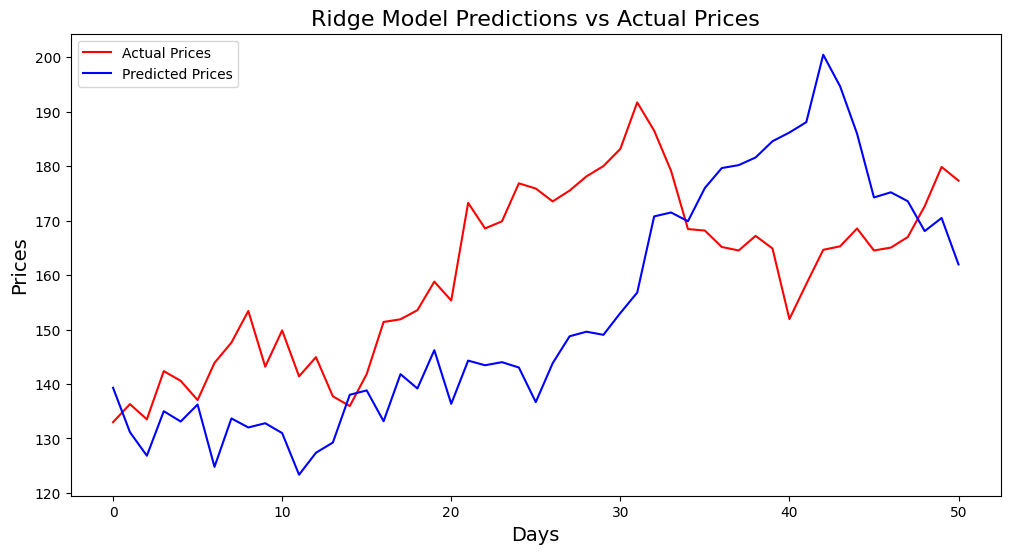

In [21]:
# Make predictions
predictions = ridge.predict(X_test)

# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions.reshape(1,-1)).reshape(-1,1)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Prices', color='red')
plt.plot(predictions_scaled, label='Predicted Prices', color='blue')
plt.title('Ridge Model Predictions vs Actual Prices', fontsize=16)
plt.xscale
plt.xlabel('Days', fontsize=14)
plt.ylabel('Prices', fontsize=14)
plt.legend()
plt.show()

####  Plotly interactive visualization
- Helps to zoom in and zoom out
- We can see the best prediction is biased towards the previous week price


In [22]:
import plotly.express as px
import plotly.graph_objects as go
datetime_array =dates[-len(y_test_scaled):]

# Convert to date string array
date_string_array = np.datetime_as_string(datetime_array, unit='D')
trace1 = go.Scatter(x=date_string_array, y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=date_string_array, y=predictions_scaled.reshape(1,-1)[0], mode='lines', name='predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


#### LSTM 

#### 3.1 Build the model

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(tf.keras.layers.LSTM(50, return_sequences=False))
model.add(tf.keras.layers.Dense(25))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

/Users/manikandanperumal/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



#### 3.2 Change the shape for data set

In [24]:
X_train_in = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_in =X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

##### 3.3 Train and Test the model

In [25]:
# Fit the model
model.fit(X_train_in, y_train, batch_size=32, epochs=100,verbose=False)

# Make predictions
predictions = model.predict(X_test_in)
y_val_lstm= model.predict(X_val.reshape(X_val.shape[0], X_val.shape[1], 1))


# Inverse transform to get the original scale for predicted prices
predictions_scaled = scaler.inverse_transform(predictions)
y_val_lstm=scaler.inverse_transform(y_val_lstm)

# Inverse transform actual test prices
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# model.eval()
# Evaluate the model performance
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Mean Squared Error: 0.036295995239615415


In [26]:
import plotly.express as px
import plotly.graph_objects as go
datetime_array =dates[-len(y_test_scaled):]

# Convert to date string array
date_string_array = np.datetime_as_string(datetime_array, unit='D')
trace1 = go.Scatter(x=date_string_array, y=y_test_scaled.reshape(1,-1)[0], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=date_string_array, y=predictions_scaled.reshape(1,-1)[0], mode='lines', name='LSTM')

# Create the layout
layout = go.Layout(
    title='Stock Price and  Ridge Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()


In [27]:
scaler.inverse_transform(X_test)

array([[ 90.636     ,  89.5886    ,  88.5113    , ..., 136.8618    ,
        137.9591    , 131.15701485],
       [ 89.5886    ,  88.5113    ,  87.9427    , ..., 137.9591    ,
        130.9264    , 131.15701485],
       [ 88.5113    ,  87.9427    ,  92.5712    , ..., 130.9264    ,
        131.525     , 131.15701485],
       ...,
       [136.6024    , 137.8793    , 132.9913    , ..., 165.1691    ,
        164.52      , 126.23393023],
       [137.8793    , 132.9913    , 136.3032    , ..., 164.52      ,
        167.2064    , 126.23393023],
       [132.9913    , 136.3032    , 133.5101    , ..., 167.2064    ,
        164.8895    , 126.23393023]])

#### Capture the predictions in data frame and combine with Ridge model

In [28]:
X_in= X.reshape(X.shape[0], X.shape[1], 1)
lstm_pred=model.predict(X_in)
lstm_pred_scaled=scaler.inverse_transform(lstm_pred)
result_df['lstm_predicted']=lstm_pred_scaled

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [29]:
result_df

,lag_40,lag_39,lag_38,lag_37,lag_36,lag_35,lag_34,lag_33,lag_32,lag_31,...,lag_6,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,earnings,lstm_predicted
0,27.0901,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,...,27.0247,26.1983,25.8691,25.7539,26.6357,26.1758,27.9489,21.421546,-94.9842,26.620790
1,26.4646,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,...,26.1983,25.8691,25.7539,26.6357,26.1758,24.7473,27.3494,19.772393,-94.9842,26.474869
2,26.7389,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,...,25.8691,25.7539,26.6357,26.1758,24.7473,25.3414,26.7105,20.216163,-94.9842,26.360363
3,25.7454,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,...,25.7539,26.6357,26.1758,24.7473,25.3414,26.9309,26.9339,21.323598,-95.0361,26.353415
4,26.3314,25.8726,25.9673,27.5669,27.9255,27.7479,27.5200,27.7494,28.7909,29.1644,...,26.6357,26.1758,24.7473,25.3414,26.9309,26.6601,26.1379,21.287356,-95.0361,26.357462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,130.0486,133.7295,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,...,183.1750,191.7036,186.5305,179.1504,168.4547,168.1751,165.0500,175.204434,2.7174,145.352829
501,133.7295,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,...,191.7036,186.5305,179.1504,168.4547,168.1751,165.1691,166.9900,173.567499,2.7174,143.801010
502,136.6024,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,147.6052,...,186.5305,179.1504,168.4547,168.1751,165.1691,164.5200,172.6500,168.078317,2.7174,142.204178
503,137.8793,132.9913,136.3032,133.5101,142.3682,140.5826,137.0513,143.8844,147.6052,153.4109,...,179.1504,168.4547,168.1751,165.1691,164.5200,167.2064,179.8600,170.488361,2.7174,140.914978


In [30]:
from xgboost import XGBRFRegressor
model = XGBRFRegressor(use_label_encoder=False, eval_metric='logloss')

model.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/xgboost/core.py:158: UserWarning:

[10:49:48] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='logloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=None, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=None, reg_alpha=None, ...)

In [31]:
y_pred=model.predict(X)
y_pred_inv_scaled=scaler.inverse_transform(np.reshape(y_pred,[-1,1]))
y_pred_inv_scaled.reshape(1,-1)[0]
result_df['xgb_predicted']=y_pred_inv_scaled.reshape(1,-1)[0]

#### utility method to get metrics across multiple moodel

In [32]:

def accuracy(df_forecast, y_train_series, seasonallity):

    method = df_forecast.columns[1:]
    rmse_results = []
    mae_results = []
    mape_results = []
    mase_results = []
    dir_accuracy_results=[]
    
    def directional_accuracy(y_true, y_pred):
    # Compare directions of changes
        y_true_dir = np.sign(np.diff(y_true))
        y_pred_dir = np.sign(np.diff(y_pred))
        return np.mean(y_true_dir == y_pred_dir)

    y = df_forecast.observed.values
    scale = np.abs(y_train_series[:-seasonallity] - y_train_series[seasonallity:])
    scale = np.average(scale)

    for i in method:
        y_hat = df_forecast[i].values
        d = y - y_hat
        mae_f = np.mean(abs(d))
        rmse_f = np.sqrt(np.mean(d**2))
        mape = np.mean(np.abs(d/y))*100
        mase = mae_f / scale
        dir_accuracy=directional_accuracy(y,y_hat)
        mae_results.append(np.round(mae_f,2))
        rmse_results.append(np.round(rmse_f,2))
        mape_results.append(np.round(mape,2))
        mase_results.append(np.round(mase,2))
        dir_accuracy_results.append(np.round(dir_accuracy,2))

    accuracy_df = pd.DataFrame({'Method':method,
                    'RMSE':rmse_results,
                    'MAE':mae_results,
                    'MAPE':mape_results,
                    'MASE':mase_results,
                   'DA':dir_accuracy_results })

    return accuracy_df

#### Compare the performance of the models

* DA - Directional Accuracy 
    * All the models have accuracy < 0.5 except xgboost
    * still Not a great fit

In [33]:

accuracy(result_df[['observed','lag_1','ridge_predicted','lstm_predicted','xgb_predicted']], result_df['observed'].values, time_step)

,Method,RMSE,MAE,MAPE,MASE,DA
0,lag_1,10.42,7.57,8.73,0.41,0.52
1,ridge_predicted,9.67,7.07,9.02,0.38,0.54
2,lstm_predicted,11.00,5.81,6.23,0.31,0.53
3,xgb_predicted,14.59,5.03,3.92,0.27,0.74


#### Visualizing all the model predictions

In [34]:
import plotly.express as px
import plotly.graph_objects as go
future_days=10
trace1 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['observed'], mode='lines', name='Stock Price')
trace2 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['lag_1'], mode='lines', name='lag 1')
trace3 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['ridge_predicted'], mode='lines', name='ridge predicted')
trace4 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['lstm_predicted'], mode='lines', name='lstm predicted')
trace5 = go.Scatter(x=df_stock.index[time_step+future_days:], y=result_df['xgb_predicted'], mode='lines', name='xgboost predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Prediction Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2,trace3,trace4,trace5], layout=layout)

# Show the plot
fig.show()

In [35]:
len(df_stock.index[time_step+future_days:]),len(result_df['observed'])


(505, 505)

In [36]:
result_df.tail(20)

,lag_40,lag_39,lag_38,lag_37,lag_36,lag_35,lag_34,lag_33,lag_32,lag_31,...,lag_5,lag_4,lag_3,lag_2,lag_1,observed,ridge_predicted,earnings,lstm_predicted,xgb_predicted
485,120.0134,132.6821,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,...,151.3959,151.8847,153.5605,158.7976,155.3361,191.7036,156.798855,25.1656,128.896790,114.501884
486,132.6821,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,...,151.8847,153.5605,158.7976,155.3361,173.2618,186.5305,170.779208,25.1656,130.909821,111.454697
487,128.2231,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,...,153.5605,158.7976,155.3361,173.2618,168.5734,179.1504,171.499132,25.1656,132.719040,114.389648
488,129.8491,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,...,158.7976,155.3361,173.2618,168.5734,169.8702,168.4547,169.894689,25.1656,134.412552,114.402763
489,127.7942,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,...,155.3361,173.2618,168.5734,169.8702,176.8530,168.1751,175.995234,25.1656,136.520279,113.398178
490,130.3678,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,...,173.2618,168.5734,169.8702,176.8530,175.8953,165.1691,179.658683,25.1656,138.367538,114.217926
491,136.4628,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,...,168.5734,169.8702,176.8530,175.8953,173.5312,164.5200,180.194844,25.1656,139.817245,111.481079
492,136.8618,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,133.7295,...,169.8702,176.8530,175.8953,173.5312,175.5163,167.2064,181.600061,25.1656,141.232407,111.896866
493,137.9591,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,133.7295,136.6024,...,176.8530,175.8953,173.5312,175.5163,178.1318,164.8895,184.585554,25.1656,142.627716,112.815277
494,130.9264,131.5250,138.3880,138.2384,136.4029,123.0958,130.0486,133.7295,136.6024,137.8793,...,175.8953,173.5312,175.5163,178.1318,180.0192,151.9268,186.178319,25.1656,143.973175,115.416908


In [37]:
last_week=df_stock.index[-1]
future_dates=[last_week+pd.Timedelta(weeks=i) for i in range(future_days)]


In [38]:
scaler.inverse_transform(np.reshape(y_val_ridge,(-1,1))).reshape(-1)

array([149.54518371, 152.24006016, 152.6361265 , 150.99172495,
       145.85185498, 147.16122475, 144.88165226, 153.55214532,
       158.01356051, 164.76716017])

In [39]:
import plotly.express as px
import plotly.graph_objects as go


trace1 = go.Scatter(x=future_dates, y=scaler.inverse_transform(np.reshape(y_val_ridge,(-1,1))).reshape(-1), mode='lines', name='ridge predicted')
trace2 = go.Scatter(x=future_dates, y=y_val_lstm.reshape(future_days), mode='lines', name='lstm predicted')

# Create the layout
layout = go.Layout(
    title='Stock Price and Prediction Over Time',
    xaxis=dict(title='Date'),
    yaxis=dict(title='Value')
)

# Create the figure with both traces
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show the plot
fig.show()

In [40]:
result_df[['earnings','observed','ridge_predicted','lstm_predicted','xgb_predicted']].tail(20)

,earnings,observed,ridge_predicted,lstm_predicted,xgb_predicted
485,25.1656,191.7036,156.798855,128.896790,114.501884
486,25.1656,186.5305,170.779208,130.909821,111.454697
487,25.1656,179.1504,171.499132,132.719040,114.389648
488,25.1656,168.4547,169.894689,134.412552,114.402763
489,25.1656,168.1751,175.995234,136.520279,113.398178
490,25.1656,165.1691,179.658683,138.367538,114.217926
491,25.1656,164.5200,180.194844,139.817245,111.481079
492,25.1656,167.2064,181.600061,141.232407,111.896866
493,25.1656,164.8895,184.585554,142.627716,112.815277
494,25.1656,151.9268,186.178319,143.973175,115.416908
